# Milan AirBnB Exploratory data analysis  
An exercise developed for CodeOp Module 3 milestone  

- Author: Margherita Serena Ferrara  
- Date: 25/11/2023  
- Contact: margheritaserena.ferrara@gmail.com

## Introduction  

This notebook illustrates an exploratory data analysis performed on the Milan AirBnB listings datasets provided by [Inside AirBnB](http://insideairbnb.com/). 
In particular for the purpose of this analysis, two datasets have been used:
- listings: listings registered on AirBnB in Milan as of September 2023
- calendar: listings availability and prices between September 2023 and September 2024

### Preliminary steps
The data used is collected and already processed by Inside AirBnB. However, some additional cleaning steps have been implemented for the purpose of this analysis.  
In particular, I have implemented the following cleaning steps:
- **removing entries which have a missing entry in the column bedroom**. AirBnB allows to select listings that have one or more bedrooms. It would have been reasonable to assume that listings with NA bedroom would be shared rooms (eg hostels). However, the data shows that most of these entries are actually recorded under 'Private rooms'. Since Inside AirBnB does not provide and explanation for such entries, I have disregarded these observations.
- **removing outliers in terms of prices.** It was found that some listings were recorded with extremely high prices per night (the highest was recorded with a price of €90,000). Having researched on AirBnb the higest listing prices, I found that, besides one listing at ~€8,000 per night and one at €900, the most expensive listings were below €700. I have therefore used removed those observations with a price above €700. Further explorations on how to deal with outliers should be done in the future, considering alternative approaches like IQR rule, or contacting Inside AirBnB to ensure better recordings of the data.

### Main findings

[main steps]
- data cleaning: removing NAs (bedrooms)
- removing outliers price in both datasets

[distr of listings and price across Milan's enighbouhoods]:
findings: pta venezia ecc wuith highest n of listings  
duomo e brera highest mean price

[corr of price]
- bedrooms  
- type of room

[price over time]
- upwards trend

### Limitations and Next steps

## Section 1: Import data & clean data

In this section, the listings and calendar datasets are imported and cleaned.


### Set up  
  
Importing the relevant packages and setting up the working folders

In [275]:
# Import revelant packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import folium
import os
from folium.plugins import HeatMap
from branca.colormap import LinearColormap

# Get folder paths
working_folder = os.getcwd()
parent_folder = os.path.dirname(working_folder)

### Listings dataset  
  
This dataset contains various information relative to the listings registered on AirBnB in Milan as of September 2023 

The following steps are implemented in this section:
- Import dataset
- Explore data available (to identify the variables format and any potential issue)
- Identify the data identifier
- Deal with missing values
- Formatting of variables such as price, which is recorded as a string.
- Dropping outliers

#### Import dataset

In [2]:
listings = pd.read_csv(parent_folder+'/MI AirBnB - dataset/listings.csv', delimiter = ',')

#### Explore data available
  
The methods ```info``` allows to review the variables available, as well as their type and the occurrences of missing values.  
This information is used in the following sections. 

In [3]:
# Explore the data
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24177 entries, 0 to 24176
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            24177 non-null  int64  
 1   listing_url                                   24177 non-null  object 
 2   scrape_id                                     24177 non-null  int64  
 3   last_scraped                                  24177 non-null  object 
 4   source                                        24177 non-null  object 
 5   name                                          24177 non-null  object 
 6   description                                   23761 non-null  object 
 7   neighborhood_overview                         13101 non-null  object 
 8   picture_url                                   24177 non-null  object 
 9   host_id                                       24177 non-null 

##### Unique identifier  
  
Since the dataset is expected to contain the list of listings registered on AirBnB in Milan as of September 2023, it is expected that each entry of the dataset is relative to a single listing (meaning, there are no duplicated ids).  
This is inspected by looking at the variable ```id``` and checking whether the number of unique ids in the datasets correpond to the number of dataset observations.

In [4]:
print(f"The datasets contains {listings['id'].nunique()} unique ids. The dataset contains {listings.shape[0]} obsevations")
if (listings['id'].nunique() == listings.shape[0]):
    print("There are no issues with the variable id")

The datasets contains 24177 unique ids. The dataset contains 24177 obsevations
There are no issues with the variable id


Given that the code above there seem to be no issues with the variable ```id```.

#### Missing values  
  
Missing values can occur for various reasons, such as errors during data collection, data entry issues, or intentional non-responses.  
In this section we deal with missing values by making the decision to drop some of these instances.

##### Drop fully missing variables  

Empty rows are dropped as they are not informative

In [5]:
listings = listings.dropna(axis=1, how='all')

##### Explore other variables that contain NAs  
  
For some variables, only a subset of observations is missing. In this section we explore which variables are and process the data based on whether the NAs are deemed to generate or not.

In [6]:
# Show variables that contain missing entris
listings.columns[listings.isna().any()]

Index(['description', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'neighbourhood',
       'bathrooms_text', 'bedrooms', 'beds', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

One of the variables that contain NA values is ```bedrooms```. Below I explore this further to understand the amount of missing values and whether there are explanations for this.

In [7]:
listings['bedrooms'].value_counts(dropna=False)

bedrooms
1.0     14361
NaN      5430
2.0      3657
3.0       587
4.0       103
5.0        27
6.0         5
7.0         3
10.0        2
8.0         1
11.0        1
Name: count, dtype: int64

AirBnB allows to select listings that have one or more bedrooms, therefore it seems odd that more tahn 5,000 entries are recorded without this information.  

This issue is furthe explored by looking at how these observations are distributed based on the variable ```property_type```, which records whether the listing is for an entire place, a private room or a shared room.  
Since studios are listed on the website as "one bedrooms" it would see that listings with NA bedroom would be shared rooms (eg hostels).

In [8]:
listings[listings['bedrooms'].isna()]['room_type'].value_counts(dropna=False)

room_type
Private room       3762
Entire home/apt    1402
Shared room         266
Name: count, dtype: int64

Of the 5430 listings with NA bedrooms, the majority are recorded as 'Private rooms'.  
Given the counterintuitivity of this finding, I drop these entries.

In [9]:
#Store these observations in another dataset
listings_no_bedroom = listings[listings['bedrooms'].isna()]

listings = listings.dropna(subset=['bedrooms'])
# Check that observations have been dropped
listings[listings['bedrooms'].isna()]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


Focussing again on the remaining variables containing NA values

In [10]:
listings.columns[listings.isna().any()]

Index(['description', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'neighbourhood',
       'bathrooms_text', 'beds', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'reviews_per_month'],
      dtype='object')

The remaining variables containing NA values are not expected to create issues for the purpose of this analysis. No other variable is dropped.

#### Format variables  
  
In this section variables are cleaned and set up in the correct format.

Based on ```listings.info()``` shows that two variables may not be in the correct format ```price``` and ```calendar_last_scraped```.  
Since we are not interested in the latter, we focus on ```price```.

In [11]:
### Print teh variable to see which symbols are in there
listings['price'].head()

1    $150.00
2    $171.00
3     $40.00
4     $94.00
6    $220.00
Name: price, dtype: object

The above shows that before converting the variable into a float it is necessary to  remove the '$' and ',' symbols.

In [12]:
listings['price'] = listings['price'].str.replace('$', '')
# The variable price can't be immediately converted as float because the symbol ',' is not considered numerical.
listings['price'] = listings['price'].str.replace(',', '').astype(float)

# Note: quicker way to achieve this would have been with 
#   calendar['adjusted_price'] = calendar['adjusted_price'].replace('[$,]', '', regex=True).astype(float)

#### Outliers  
  
The purpose of this EDA is to observe how listings price differs across neighbourhoods, or by listing type or other features.  
It is therefore fundamental that this variable is realiable.  

In this section it is found that some listings were recorded with extremely high prices per night (the highest was recorded with a price of €90,000). Having researched on AirBnb the higest listing prices, I found that, besides one listing at ~€8,000 per night and one at €900, the most expensive listings were below €700. I have therefore used removed those observations with a price above €700. Further explorations on how to deal with outliers should be done in the future, considering alternative approaches like IQR rule, or contacting Inside AirBnB to ensure better recordings of the data.  

The screeshot below shows the most expensive listings in Milan that the website currently shows:  
![AirBnB most expensive listings](./MI_AirBnB_most_expensive_listings_Euro.png)

In [13]:
# Only keep listings with price below 700 euros.
listings_no_outliers = listings[listings['price'] <= 700]

Visualise how data distribution changed between the original dataset and the one with only listings below 700€  
To do so, the chart below compares the boxplot and histogram of the two datasets.

Text(0, 0.5, 'Number of listings')

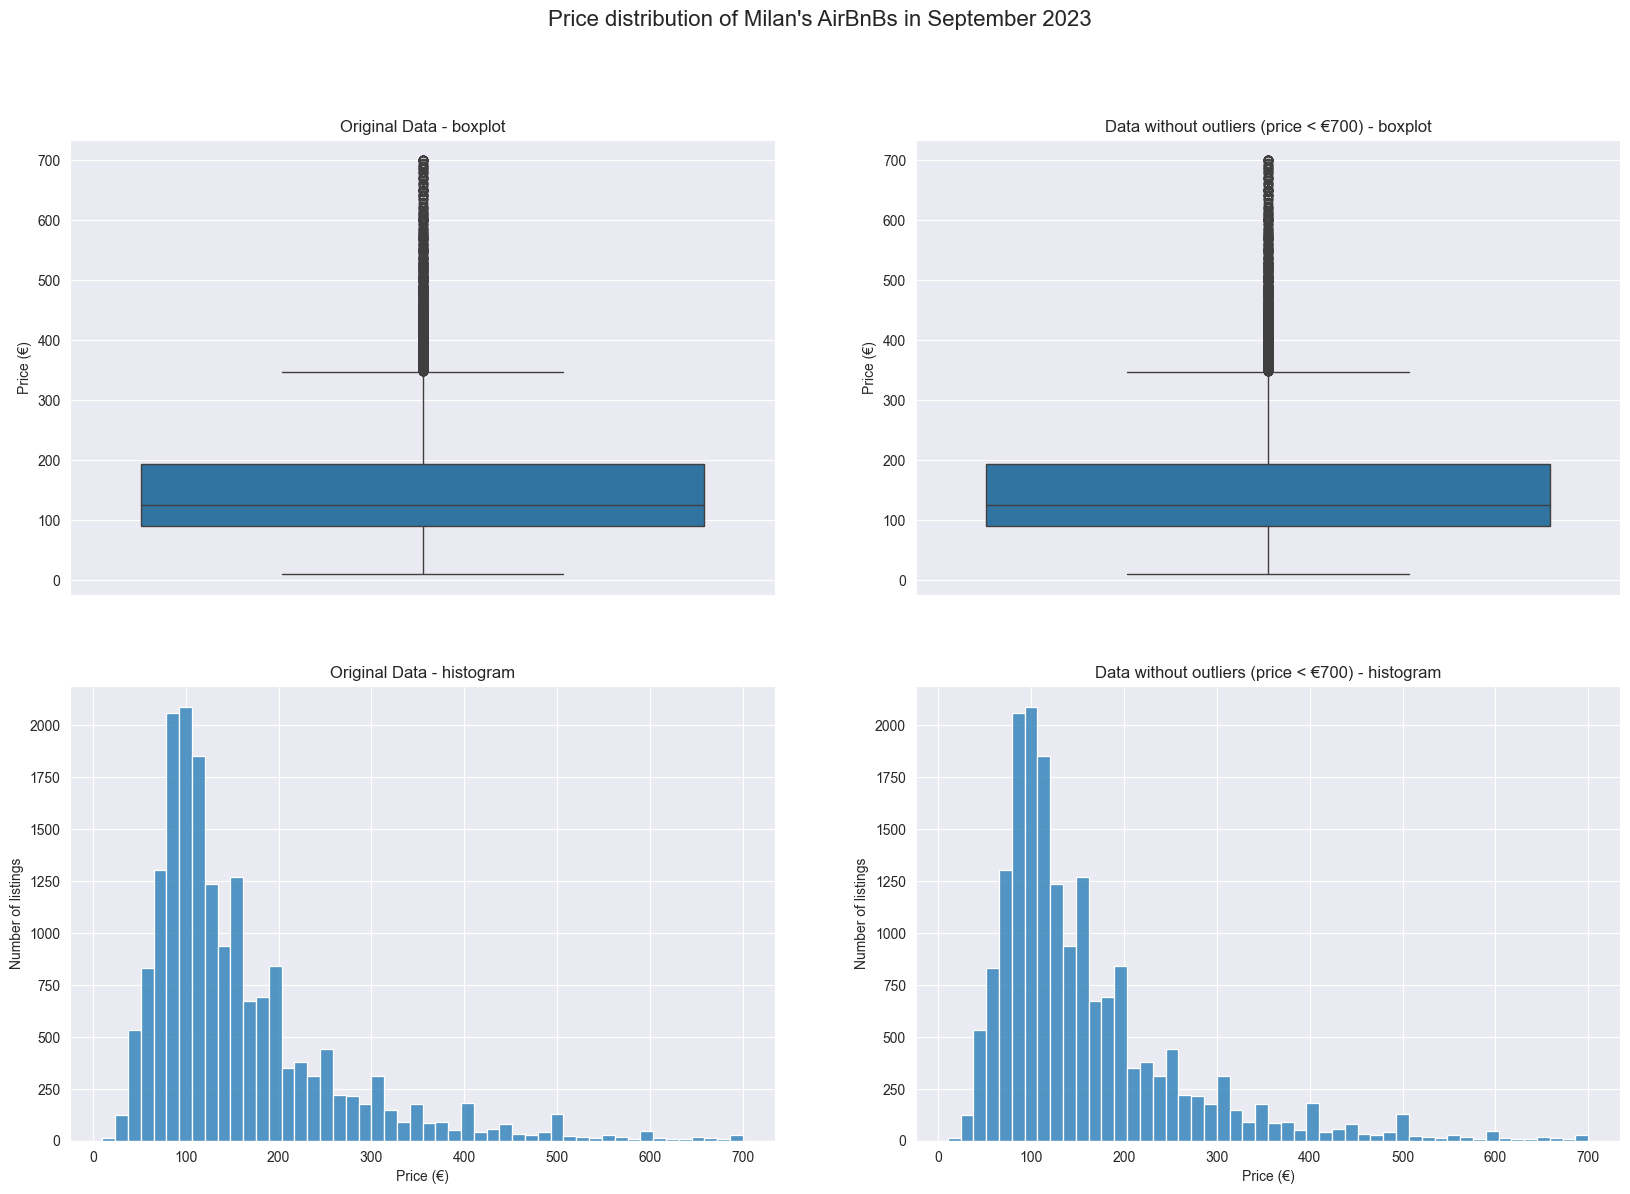

In [70]:
# Create subplot
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2,
    figsize=(20,13)
)

# Set up style
sns.set_style("darkgrid")

# Title
fig.suptitle(
    "Price distribution of Milan's AirBnBs in September 2023",
    fontsize = 16)

# Price boxplot (all observations)
sns.boxplot(
    data = listings,
    y = 'price',
    ax = axes[0,0]
)
axes[0,0].set_title("Original Data - boxplot")
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Price (€)")

# Price boxplot (without outliers)
sns.boxplot(
    data = listings_no_outliers,
    y = 'price',
    ax = axes[0,1]
)
axes[0,1].set_title("Data without outliers (price < €700) - boxplot")
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("Price (€)")

# Price histogram (all observations)
sns.histplot(
    data=listings, 
    x="price",
    bins = 50,
    ax = axes[1,0]
    )
axes[1,0].set_title("Original Data - histogram")
axes[1,0].set_xlabel("Price (€)")
axes[1,0].set_ylabel("Number of listings")

# Price histogram (without outliers)
sns.histplot(
    data=listings_no_outliers, 
    x="price",
    bins = 50,
    ax = axes[1,1]
    )
axes[1,1].set_title("Data without outliers (price < €700) - histogram")
axes[1,1].set_xlabel("Price (€)")
axes[1,1].set_ylabel("Number of listings")

In [44]:
listings_no_outliers['price'].describe()

count    18345.000000
mean       158.063069
std        103.611533
min         10.000000
25%         90.000000
50%        125.000000
75%        193.000000
max        700.000000
Name: price, dtype: float64

In [48]:
# Show basic descritive statistics to see how they differ across datasets

# Dataset with outliers
price_stats = pd.concat(
    [
        listings['price'].describe(), 
        pd.Series(listings['price'].median(), name='Median')
        ], 
    axis=0
    )
price_stats = price_stats.rename(index={0: 'Median'})
price_stats.name = 'Price statistics (with outliers)'

# Dataset without outliers
price_stats_no_outliers = pd.concat(
    [
        listings_no_outliers['price'].describe(), 
        pd.Series(listings_no_outliers['price'].median(), name='Median')
        ], 
    axis=0
    )
price_stats_no_outliers = price_stats_no_outliers.rename(index={0: 'Median'})
price_stats_no_outliers.name = 'Price statistics (without outliers)'

# Merge datasets for ease of read
stats = pd.merge(
    price_stats, 
    price_stats_no_outliers, 
    left_index=True,
    right_index=True, 
    how = 'outer')
print(stats)

        Price statistics (with outliers)  Price statistics (without outliers)
count                        18747.00000                         18345.000000
mean                           206.14333                           158.063069
std                            989.37974                           103.611533
min                             10.00000                            10.000000
25%                             90.00000                            90.000000
50%                            128.00000                           125.000000
75%                            200.00000                           193.000000
max                          90000.00000                           700.000000
Median                         128.00000                           125.000000


The charts above show the presence of extreme values that significantly deviate from the central tendency, making the charts illegible.  
Moreover, in the dataset without outliers the mean was almost twice as the median and, despite a 75th percentile of €200 the maximum value was €90000.  

Having removed the most extreme observations the charts are more readable and the data seems more reasonable.  
In particular, the data shows that a large proportion of listings have a price around ~€75 and ~€200.  
Above €200 the number of listings is much lower. As expected there is a long tail of listings with prices that go up to €700.

In [49]:
# Rename datasets
listings_incl_outliers = listings.copy()  # Create a copy to avoid modifying the original DataFrame
listings = listings_no_outliers.copy()  # Create a copy to avoid modifying the original DataFrame

### Calendar
  
The calendar dataset contains the listings availability and prices between September 2023 and September 2024  
   
The following steps are implemented in this section:
- Import dataset
- Explore data available (to identify the variables format and any potential issue)
- Identify the data identifier
- Deal with missing values
- Formatting of variables such as price, which is recorded as a string.
- Dropping outliers

#### Import dataset

In [50]:
calendar = pd.read_csv(parent_folder+'/MI AirBnB - dataset/calendar.csv')

#### Explore data available  
  
The methods ```info``` allows to review the variables available, as well as their type and the occurrences of missing values.  
This information is used in the following sections. 

In [51]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824261 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 471.3+ MB


The above shows that the variables price, price_adjusted and date are identified as objects.  
These will be correctly formatted later in this section.

##### Unique identifiers  
  
Given that this dataset contains the listings availability and prices between September 2023 and September 2024, it is expected that the listings ids will be repeated more than once.  
Therefore this check is not performed. On the other hand, I check whether thec ```listing_id``` does not have missing values.

In [52]:
calendar[calendar['listing_id'].isna()]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights


The output above shows that there are no missing values for the variable ```listing_id```.

#### Missing values  
  
Missing values can occur for various reasons, such as errors during data collection, data entry issues, or intentional non-responses.  
In this section we deal with missing values by making the decision to drop some of these instances.

In [54]:
columns_with_na = calendar.columns[calendar.isna().any()]

print(columns_with_na)

Index(['price', 'adjusted_price', 'minimum_nights', 'maximum_nights'], dtype='object')


##### Drop fully missing variables  

Empty rows are dropped as they are not informative

In [55]:
calendar = calendar.dropna(axis=1, how='all')
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824261 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 471.3+ MB


```calendar.info()``` shows that no variable was fully missing.
However, some variables have NA values(). We explore these in the rest of the section.

In [56]:
# Number of observations with NA()
calendar[columns_with_na].isna().sum()

price             171
adjusted_price    171
minimum_nights     15
maximum_nights     15
dtype: int64

A relatively small amount of observations have Nas. 
It would be reasonable to assume that price is NA only in case when the listing is not available.

In [63]:
calendar['available'][calendar['price'].isna()].value_counts()

available
t    171
Name: count, dtype: int64

All observations with NA price are available. This seems counterintuitive.  
For this reason, these observations are dropped.

In [64]:
calendar = calendar.dropna(subset=['price'])

Note that all observations with NA price were also those with missing adjusted_price.

In [65]:
calendar[columns_with_na].isna().sum()

price              0
adjusted_price     0
minimum_nights    15
maximum_nights    15
dtype: int64

#### Format variables  
  
In this section variables are cleaned and set up in the correct format.

Based on ```listings.info()``` shows that two variables may not be in the correct format ```price``` and ```date```.  

In [66]:
# Convert price in float
calendar['price'] = calendar['price'].replace('[$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace('[$,]', '', regex=True).astype(float)

# Convert date in datetime
calendar['date'] = pd.to_datetime(calendar['date'], format = "%Y-%m-%d")
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8824090 entries, 0 to 8824260
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 538.6+ MB


#### Outliers  
  
For consistency, the same methodology used for the dataset ```listings``` is applied here. 

In [73]:
# Only keep listings with price below 700 euros.
calendar_no_outliers = calendar[calendar['price'] <= 700]

Text(0, 0.5, 'Number of listings')

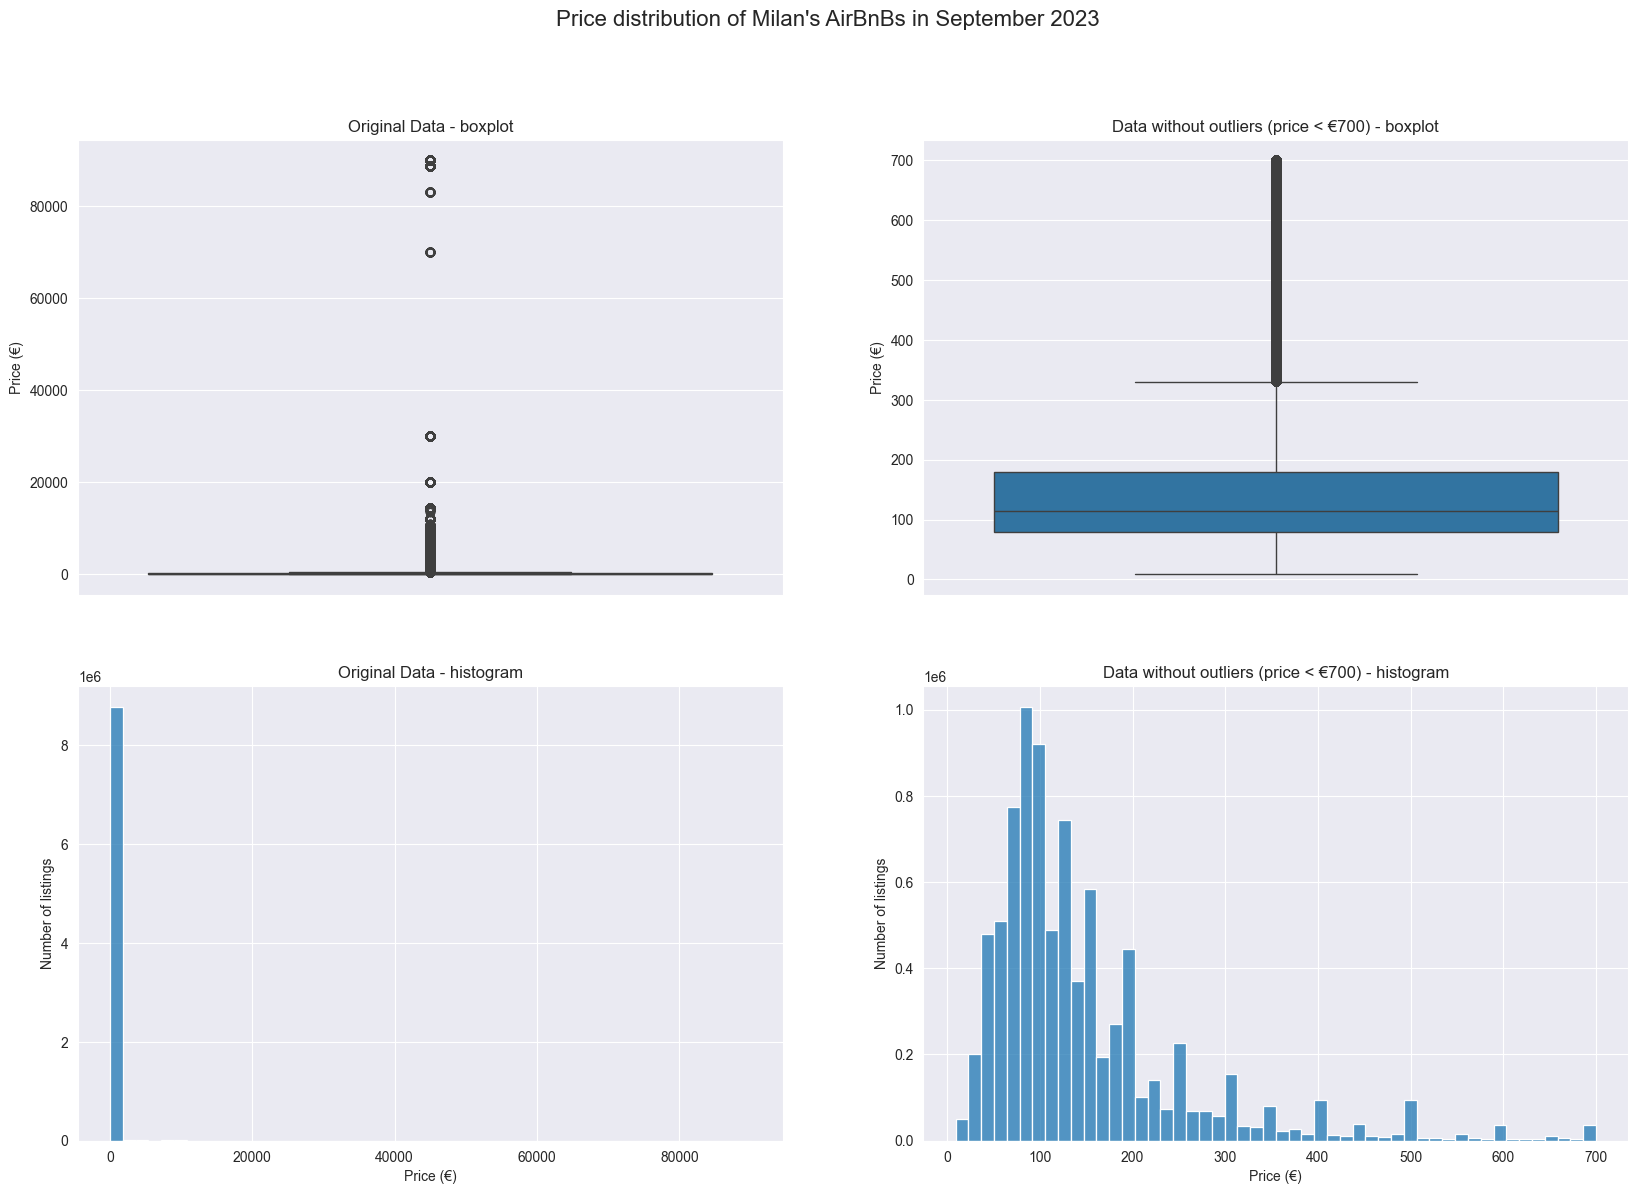

In [72]:
# Create subplot
fig, axes = plt.subplots(
    nrows=2, 
    ncols=2,
    figsize=(20,13)
)

# Set up style
sns.set_style("darkgrid")

# Title
fig.suptitle(
    "Price distribution of Milan's AirBnBs in September 2023",
    fontsize = 16)

# Price boxplot (all observations)
sns.boxplot(
    data = calendar,
    y = 'price',
    ax = axes[0,0]
)
axes[0,0].set_title("Original Data - boxplot")
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Price (€)")

# Price boxplot (without outliers)
sns.boxplot(
    data = calendar_no_outliers,
    y = 'price',
    ax = axes[0,1]
)
axes[0,1].set_title("Data without outliers (price < €700) - boxplot")
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("Price (€)")

# Price histogram (all observations)
sns.histplot(
    data=calendar, 
    x="price",
    bins = 50,
    ax = axes[1,0]
    )
axes[1,0].set_title("Original Data - histogram")
axes[1,0].set_xlabel("Price (€)")
axes[1,0].set_ylabel("Number of listings")

# Price histogram (without outliers)
sns.histplot(
    data=calendar_no_outliers, 
    x="price",
    bins = 50,
    ax = axes[1,1]
    )
axes[1,1].set_title("Data without outliers (price < €700) - histogram")
axes[1,1].set_xlabel("Price (€)")
axes[1,1].set_ylabel("Number of listings")

In [77]:
# Show basic descritive statistics to see how they differ across datasets

# Dataset with outliers
price_stats = pd.concat(
    [
        calendar['price'].describe(), 
        pd.Series(calendar['price'].median(), name='Median')
        ], 
    axis=0
    )
price_stats = price_stats.rename(index={0: 'Median'})
price_stats.name = 'Price statistics (with outliers)'

# Dataset without outliers
price_stats_no_outliers = pd.concat(
    [
        calendar_no_outliers['price'].describe(), 
        pd.Series(calendar_no_outliers['price'].median(), name='Median')
        ], 
    axis=0
    )
price_stats_no_outliers = price_stats_no_outliers.rename(index={0: 'Median'})
price_stats_no_outliers.name = 'Price statistics (without outliers)'

# Merge datasets for ease of read
stats = pd.merge(
    price_stats, 
    price_stats_no_outliers, 
    left_index=True,
    right_index=True, 
    how = 'outer')
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.reset_option('display.float_format')

# Show stats (not showing count because the dataset is very big and all teh table would be shown in scientific notation)
print(stats[stats.index != 'count'])

        Price statistics (with outliers)  Price statistics (without outliers)
mean                          208.067006                           147.895835
std                          1030.790226                           110.661986
min                             9.000000                             9.000000
25%                            80.000000                            80.000000
50%                           119.000000                           115.000000
75%                           190.000000                           180.000000
max                         90000.000000                           700.000000
Median                        119.000000                           115.000000


Having removed the most extreme observations leads to a data distribution similar to that in the dataset ```listings```.

## Section 2: Exploratory data analysis  
  
In this section I explore the data. In particular, the analysis focusses on:
- distribution of listings prices based on features such as number of bedrooms and property type;
- distribution of listings across Milan's neighbourhoods
- distribution of prices across Milan's neighbourhoods
- evolution of prices over the year

### Distribution of prices based on listings features  
  
It is expected that prices differ based on the listing's features.  
In this section boxplots are used to explore the price distribution based on the property type and number of bedrooms.  
  
Additional features may determine different levels of prices such as location or amenities.  
Location is explored later in the section.

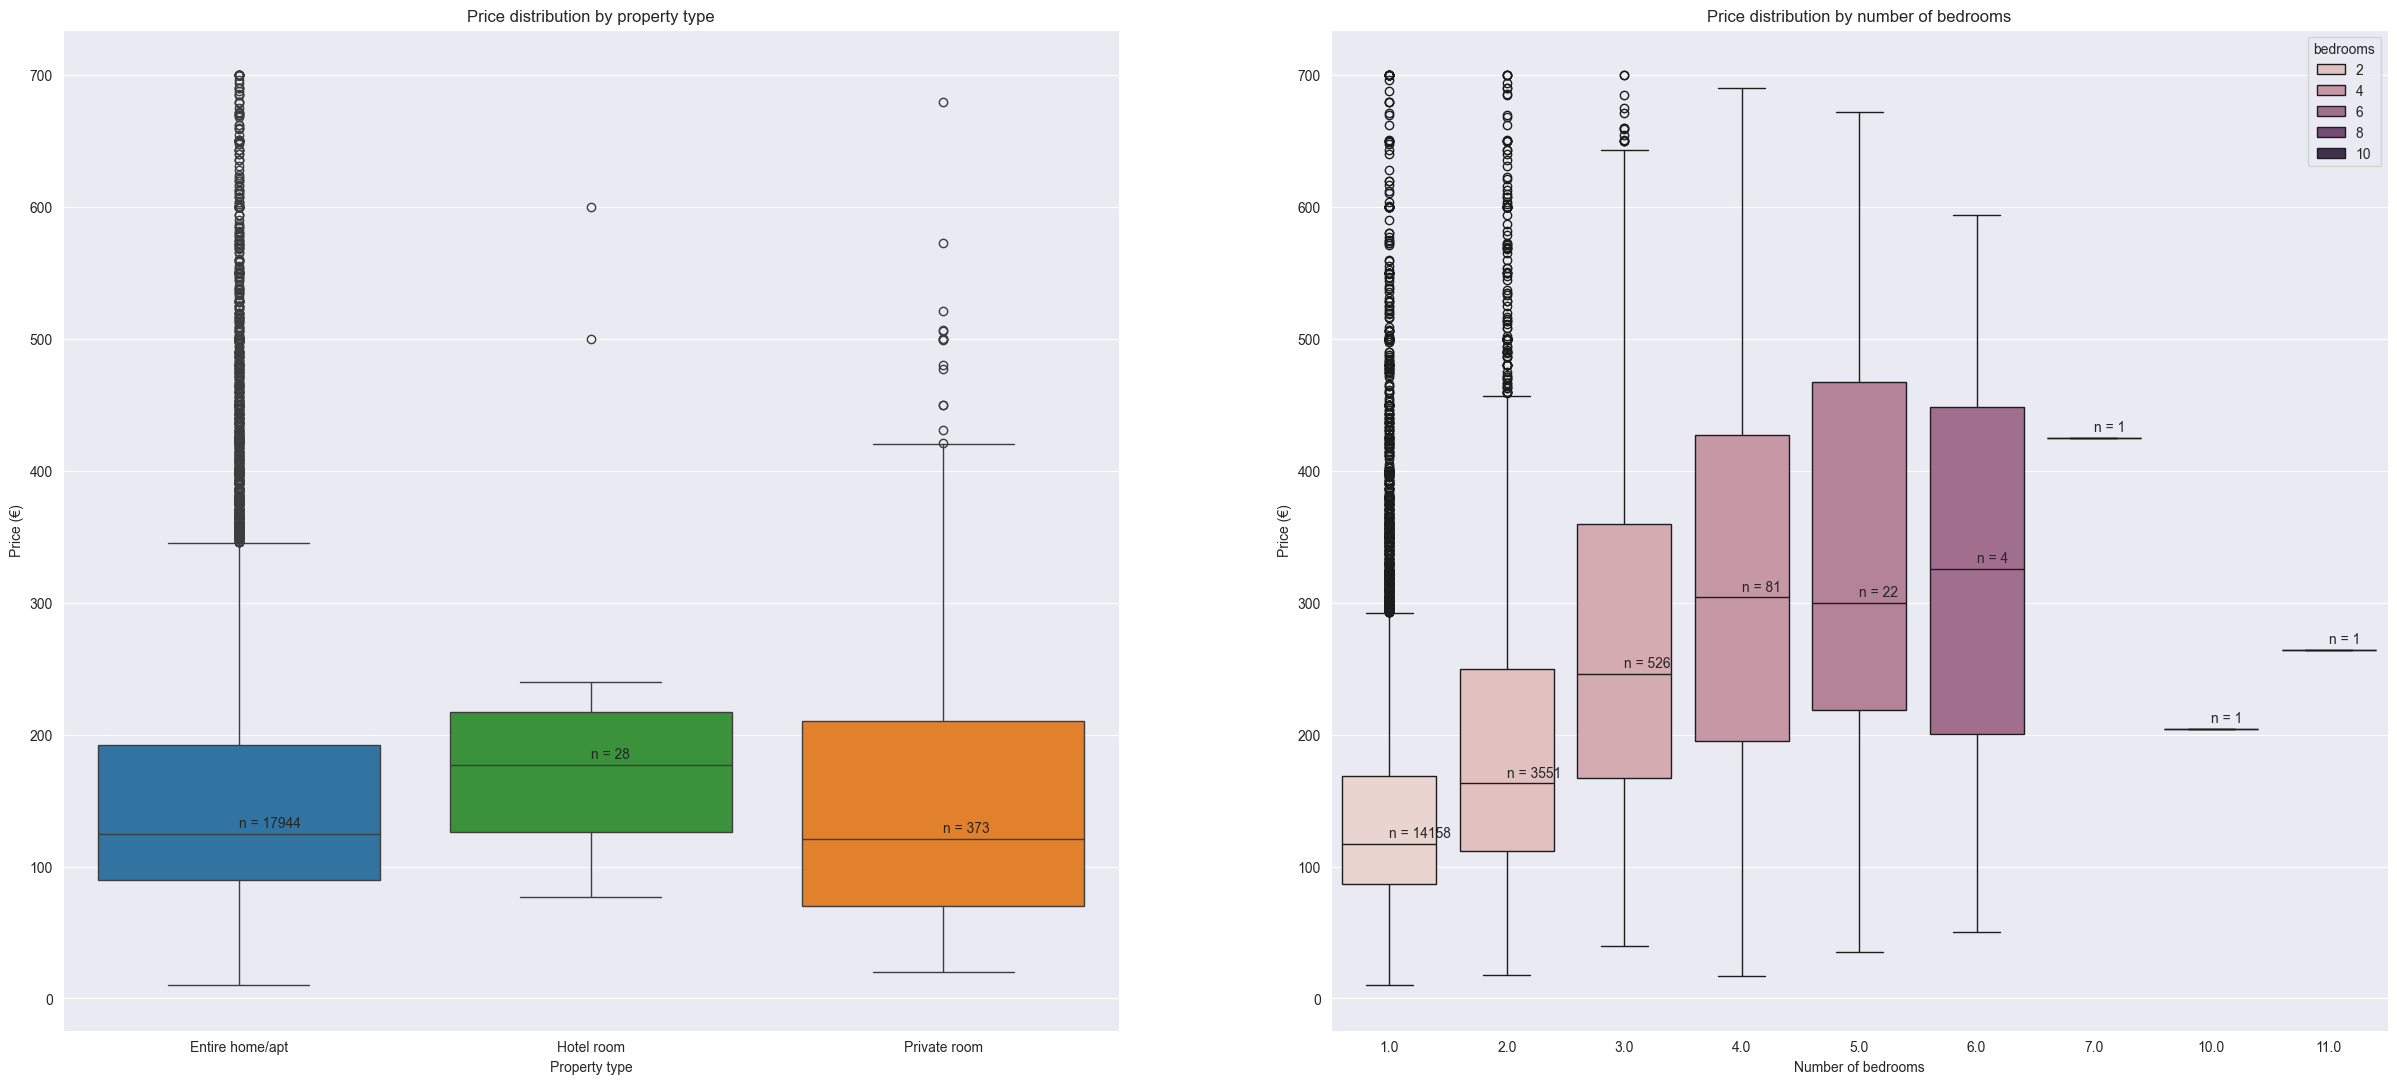

In [107]:
# Set up useful info for the chart
features_list = {
    'room_type' : 
        {'title_name': 'Price distribution by property type', 
        'x_axis_name' : 'Property type'},
    'bedrooms':
        {'title_name': 'Price distribution by number of bedrooms', 
        'x_axis_name' : 'Number of bedrooms'}
    }

features_list_table = pd.DataFrame(features_list)

# Draw figure
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(30,13)
)

# Price by room type

chart_pos = 0
for f in features_list_table.columns:

    # List of room types (used to ensure that the order of how the data is shows is the same as the labels pasted over)
    p_types = np.unique(listings[f])

    # Plot data
    boxplot_axis = sns.boxplot(
        data = listings,
        y = 'price',
        x = f,
        ax = axes[chart_pos],
        order = p_types,
        hue = f
    )

    # Add labels with number of observations
    for p_type in p_types:
        # X coodinate of the label set as the indices of the property type for which we are calculating the observations
        x = np.argmax(p_types == p_type)
        # Y coordinate is set to be slightly above the median line
        y = np.median(listings[listings[f] == p_type]['price']) + 5
        # Calculate number of observations
        nobs = listings[listings[f] == p_type].shape[0]
        # create label
        text = f"n = {nobs}"
        #print(f"{x} {num_bedrooms} {np.median(listings[listings['room_type'] == num_bedrooms]['price'])} {y} {text}")

        # Add text to boxplot
        boxplot_axis.text(
            x = x,
            y = y,
            s = text
        )

    axes[chart_pos].set_title(features_list_table.loc['title_name'][f])
    axes[chart_pos].set_ylabel("Price (€)")
    axes[chart_pos].set_xlabel(features_list_table.loc['x_axis_name'][f])
    chart_pos +=1

    

plt.show()

The price distribution by property type shows that:
- The number of listings in hotels much smaller than those listed as entire homes or private rooms. This seems to be in line with the fact that AirBnB was developed mostly to rent private properties.
- Most listings are categorised as 'Entire homes'
- The median price of listings in hotel rooms is the highest, however, not substantially
- There is a long tail of observations above the 75th percentile in the Entire home category.

The price distribution by number of bedrooms shows that:
- there are only very few listings with 6 or more bedrooms. These boxplots will therefore be ignored as they have low statistical validity.
- The remaining of the boxplots show, as expected, that price increases as the number of bedrooms is higher.
 

### istribution of listings across Milan's neighbourhoods and its prices
  
In this section, we present a map that will show:
- the number of listings per neighbourhood;
- the listings average price per neighbourhood;
- the listings median price per neighbourhood. 

In [276]:
# create summary table
neighborhood_counts = listings['neighbourhood_cleansed'].value_counts().reset_index()
neighborhood_counts.columns = ['neighbourhood', 'listing_count']

neighborhood_med_price = listings.groupby('neighbourhood_cleansed')['price'].median().reset_index()
neighborhood_med_price.columns = ['neighbourhood', 'median_price']

neighborhood_avg_price = listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
neighborhood_avg_price.columns = ['neighbourhood', 'avg_price']

# Merge datasets
neighborhood_summary_stats = pd.merge(
    neighborhood_counts,
    neighborhood_med_price,
    on = 'neighbourhood',
    how = 'left'
)

neighborhood_summary_stats = pd.merge(
    neighborhood_summary_stats,
    neighborhood_avg_price,
    on = 'neighbourhood',
    how = 'left'
)

# Sort the data by 'listing_count' in descending order and identify top 20 neigbourhoods per number of listings
neighborhood_summary_stats = neighborhood_summary_stats.sort_values(by='listing_count', ascending=False)

neighborhood_summary_stats['top_20'] = 0
neighborhood_summary_stats.loc[:19, 'top_20'] = 1

neighborhood_summary_stats['grouped_neighbourhood'] = neighborhood_summary_stats.apply(
    lambda row: row['neighbourhood'] if row['top_20'] == 1 
    else 'Other', axis=1)

neighborhood_summary_stats

,neighbourhood,listing_count,median_price,avg_price,top_20,grouped_neighbourhood
0,BUENOS AIRES - VENEZIA,1391,142.0,169.368081,1,BUENOS AIRES - VENEZIA
1,DUOMO,1071,241.0,259.396825,1,DUOMO
2,SARPI,884,135.0,166.132353,1,SARPI
3,BRERA,800,211.0,246.888750,1,BRERA
4,NAVIGLI,790,131.0,161.718987,1,NAVIGLI
...,...,...,...,...,...,...
81,MUGGIANO,4,91.5,104.500000,0,Other
82,PARCO AGRICOLO SUD,3,86.0,102.333333,0,Other
83,SACCO,3,50.0,54.000000,0,Other
84,PARCO NORD,1,153.0,153.000000,0,Other


Draw map

In [277]:
# Import neighbourhoods
geojson_path = parent_folder+'/MI AirBnB - dataset/neighbourhoods.geojson'

In [293]:
# Identify median latitude and longitude to center the map
median_latitude = listings['latitude'].median()
median_longitude = listings['longitude'].median()

# Draw map
milan_map = folium.Map(
    # starting location
    location = [median_latitude, median_longitude],
    zoom_start = 10.5,
    tiles = 'OpenStreetMap'
)


# Note: looping over the three statistics to add layers to the chart does not work as it is not possible to flick through them.
# I am adding the three layers separately

# Average price

m_prices = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_summary_stats,
    columns=['neighbourhood', 'median_price'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median price',
    
    highlight= True,
    nan_fill_color="grey",
    name='Median price'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
price_data_indexed = neighborhood_summary_stats.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in m_prices.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['median_price'] = int(price_data_indexed.loc[s['properties']['neighbourhood'], 'median_price'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['median_price'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'median_price'],
    aliases=['Neighborhood', 'Median price'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(m_prices.geojson)

# Average price

a_prices = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_summary_stats,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average price',
    
    highlight= True,
    nan_fill_color="grey",
    name='Average price'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
price_data_indexed = neighborhood_summary_stats.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in a_prices.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['average_price'] = int(price_data_indexed.loc[s['properties']['neighbourhood'], 'avg_price'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['average_price'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'average_price'],
    aliases=['Neighborhood', 'Average price'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(a_prices.geojson)

# Number of listings

cp = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_summary_stats,
    columns=['neighbourhood', 'listing_count'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Listings',
    
    highlight= True,
    nan_fill_color="grey",
    name='Number of listings'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
data_indexed = neighborhood_summary_stats.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['listing_count'] = int(data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['listing_count'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'listing_count'],
    aliases=['Neighborhood', 'Listings'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(cp.geojson)

folium.LayerControl().add_to(milan_map)

milan_map

p_prices = folium.Choropleth(
    geo_data=geojson_path,
    data=neighborhood_summary_stats,
    columns=['neighbourhood', 'avg_price'],
    key_on='feature.properties.neighbourhood',  # GeoJSON property for matching
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median price',
    
    highlight= True,
    nan_fill_color="grey",
    name='Median price'
).add_to(milan_map)

# creating a state indexed version of the dataframe so we can lookup values
price_data_indexed = neighborhood_summary_stats.set_index('neighbourhood')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in p_prices.geojson.data['features']:
    #print(s['properties'])
    #print(s['properties']['neighbourhood'])
    try: 
        #print(state_data_indexed.loc[s['properties']['neighbourhood'], 'listing_count'])
        s['properties']['average_price'] = int(price_data_indexed.loc[s['properties']['neighbourhood'], 'avg_price'])
        #print(s['properties']['listing_count'])
    except:
        s['properties']['average_price'] = 0
    #print(s['properties'])

folium.GeoJsonTooltip(
    fields=['neighbourhood', 'average_price'],
    aliases=['Neighborhood', 'Average price'],
    labels=True,
    sticky=True,
    style= "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
).add_to(p_prices.geojson)


In [ ]:
_ = sns.barplot(
    data = neighborhood_counts,
    y = 'grouped_neighbourhood',
    x = 'listing_count'
)
_ = plt.xlabel('Number of Listings')
_ = plt.ylabel('Neighbourhoods')
_ = plt.title('Top 20 Neighborhoods by Number of Listings')
plt.show()

### Price distribution

In [ ]:
# Define the "subplot".
fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(30,13)
)

# Set up a stype
sns.set_style("darkgrid")

# Let's add a general title.
fig.suptitle("TO UDPATE")

# Add subtitles to each subplot
axes[0].set_title("Number of listings")
axes[0].set_title("Average price")

sns.barplot(
    data = neighborhood_counts,
    y = 'grouped_neighbourhood',
    x = 'listing_count',
    order = neighborhood_counts.sort_values(
        by = 'listing_count', ascending = False)['grouped_neighbourhood'],
    ax = axes[0]

)

sns.barplot(
    data = neighborhood_avg_price,
    y = 'grouped_neighbourhood',
    x = 'avg_price',
    order = neighborhood_avg_price.sort_values(
        by = 'listing_count', ascending = False)['grouped_neighbourhood'],
    ax = axes[1]
)

plt.show()

### Other determinants of price

- first on separate datasets
- what are the min and max data?
- what is the distr of prices of listings?
- have prices changed over time?

### Price and listings over time

In [ ]:
mi_listings['date'].describe()

In [ ]:
mi_listings['equal_prices'] = mi_listings['price_x'] == mi_listings['price_y']
value_counts = mi_listings['equal_prices'].value_counts(normalize=True)

#
plt.figure(figsize=(6, 6))
plt.pie(
    value_counts, 
    labels=value_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightcoral', 'lightskyblue'])
plt.title('Proportion of Equal and Unequal Prices')
plt.show()

In [ ]:
sns.lineplot(
    data = mi_listings,
    x = "date",
    y = "price_y"
)


huge peak in may - salone and summer?